# Derive Wind Speed from the Direct Model Outputs of ICON-CH1-EPS

This notebook demonstrates the full workflow for accessing perturbed ICON-CH1-EPS wind forecast data, calculating wind speed and visualizing the results. The data is provided by MeteoSwiss as part of Switzerland’s [Open Government Data (OGD) initiative](https://www.meteoswiss.admin.ch/services-and-publications/service/open-data.html).

While ICON-CH1-EPS provides wind as eastward and northward components, users are typically more interested in the **horizontal wind speed**. In this notebook, you'll see how to compute it in a single line using the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library. You will also learn how to retrieve the **maximum wind speed across the ensemble members** from the perturbed forecast.

The core functionality is powered by the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — developed in-house to simplify working with numerical weather model data. It includes the `ogd_api` module for data access, along with utilities for applying temporal and spatial operators to model output, such as calculating wind speed and regridding.

For visualization, this notebook uses the [Matplotlib](https://matplotlib.org/stable/index.html) library, a well-known visualization tool in Python. 

---

## 🔍 **What You’ll Do in This Notebook**

 🛰️  **Retrieve**  
    Fetch perturbed ICON-CH1-EPS forecast data (here the 10m eastward and 10m northward wind) via the `ogd_api` module.

 📐  **Calculate**  
    Calculate horizontal wind speed using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `wind` module and apply ensemble statistics.

 🧭  **Regrid**  
    Interpolate ICON-CH1-EPS data from its native, icosahedral grid to the regular Swiss grid [LV95 (EPSG:2056)](https://epsg.io/2056).

 🌍  **Visualize**  
    Plot each ensemble member on a map using [Matplotlib](https://matplotlib.org/stable/index.html).

---

## Retrieving Forecasts
In this first part, we retrieve perturbed eastward and northward wind forecast data produced by ICON-CH1-EPS. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### 📁  Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON-CH1/2-EPS forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH1-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH2-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2-EPS collection as seen in the STAC browser interface.


![browser-ch2.png](./images/browser-ch2.png)

### Creating Requests
To retrieve the forecast data, we first define API requests using the `ogd_api.Request` class. In this example, two requests are made: one for the eastward wind at 10 meters above the surface (`U_10M`) and one for the northward wind at the same height (`V_10M`). Each request targets perturbed data at the initialization time of the forecast.

>⏰ **Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [1]:
from datetime import datetime, timezone
from meteodatalab import ogd_api

# Set default date of today midnight in UTC
today_midnight_utc = datetime.now(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

# retrieve eastward wind at 10m
req_U10 = ogd_api.Request(
    collection="ogd-forecasting-icon-ch1",
    variable="U_10M",
    reference_datetime=today_midnight_utc,
    perturbed=True,
    horizon="P0DT0H",
)

# retrieve northward wind at 10m
req_V10 = ogd_api.Request(
    collection="ogd-forecasting-icon-ch1",
    variable="V_10M",
    reference_datetime=today_midnight_utc,
    perturbed=True,
    horizon="P0DT0H",
)

Each argument in the request serves the following purpose:

| Argument             | Description |
|----------------------|-------------|
| `collection`         | Forecast collection to use (e.g., `ogd-forecasting-icon-ch1`). |
| `variable`           | Meteorological variable of interest (`U_10M` = eastward wind at 10m and `V_10M` = northward wind at 10m). |
| `reference_datetime` | Initialization time of the forecast in **UTC**, provided as either:<br>- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) object (e.g.,<br> &nbsp; `datetime.datetime(2025, 5, 22, 9, 0, 0, tzinfo=datetime.timezone.utc)`) <br>- [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Combined_date_and_time_representations) date string (e.g., `"2025-05-22T09:00:00Z"`)|
| `perturbed`          | If `True`, retrieves ensemble forecast members; if `False`, returns the deterministic forecast. |
| `horizon`            | Forecast lead time, provided as either:<br>– [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) object (e.g., `datetime.timedelta(hours=0)`) <br>– [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Durations) duration string (e.g., `"P0DT0H"`)|

### Retrieving Data
We now send our requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **[xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)**, which is efficient for handling multi-dimensional data.

> 💡 **Tip**: Use temporary caching with earthkit-data to skip repeated downloads — it's auto-cleaned after the session.
> *For more details, see the [earthkit-data caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html)*.

> 💡 **Hint**: If you get an error message containing `HTTPError: 403 Client Error: Forbidden for url`, you may be trying to retrieve data older than 24h hours! Please adjust your requests.

In [2]:
from earthkit.data import config
config.set("cache-policy", "temporary")

da_U = ogd_api.get_from_ogd(req_U10)
da_V = ogd_api.get_from_ogd(req_V10)

## Data Preprocessing

Once the data has been loaded, continue with the preprocessing of the data. The following preprocessing steps
are summarized here:
- Calculate horizontal wind speed
- Determine the maximum wind speed across all ensemble members
- Regrid the data to the regular Swiss grid EPSG:2056

### Calculating Wind Speed
The horizontal wind speed can be computed using the `speed()` function provided by the `wind` module in [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/). This function takes two [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) objects as input: the eastward (`da_U`) and northward (`da_V`) wind component.

In [3]:
from meteodatalab.operators import wind

wind_speed = wind.speed(da_U, da_V)
wind_speed

<xarray.DataArray (eps: 10, ref_time: 1, lead_time: 1, z: 1, cell: 1147980)> Size: 46MB
array([[[[[2.2313738e-04, 2.2313738e-04, 2.2313738e-04, ...,
           4.2712159e+00, 3.5459986e+00, 3.4944365e+00]]]],



       [[[[2.6677834e-04, 2.6677834e-04, 2.6677834e-04, ...,
           3.5540323e+00, 3.3738849e+00, 3.6925445e+00]]]],



       [[[[3.3518497e-04, 3.3518497e-04, 3.3518497e-04, ...,
           4.5800691e+00, 4.2541804e+00, 4.2641006e+00]]]],



       ...,



       [[[[1.5070770e-04, 1.5070770e-04, 1.5070770e-04, ...,
           4.9062471e+00, 4.3315573e+00, 4.3286099e+00]]]],



       [[[[2.6306938e-04, 2.6306938e-04, 2.6306938e-04, ...,
           4.5332122e+00, 4.3284273e+00, 4.5554523e+00]]]],



       [[[[2.1520998e-04, 2.1520998e-04, 2.1520998e-04, ...,
           3.2227566e+00, 2.7834487e+00, 2.8594351e+00]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 80B 1 2 3 4 5 6 7 8 9 10
  * ref_time    (ref_time) datetime64[ns] 8B 2025-05-26
  * lead_time   (lead_time) timedelta64[ns] 8B 00:00:00
  * z           (z) int64 8B 10
    lon         (cell) float32 5MB 17.71 17.69 17.7 17.7 ... 12.81 12.81 12.8
    lat         (cell) float32 5MB 50.24 50.24 50.24 50.23 ... 50.06 50.05 50.04
    valid_time  (ref_time, lead_time) datetime64[ns] 8B 2025-05-26
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.core.metadata.WrappedMetadata object at 0x76...
    parameter:    {'centre': 'lssw', 'paramId': 500025, 'shortName': 'SP_10M'...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  heightAboveGround
    origin_z:     0.0

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 10 members (for perturbed data)
- `ref_time`: single reference time (e.g. default date of today midnight)
- `lead_time`: single lead time (e.g +0 hours)
- `z`: vertical level (e.g. 10m above ground)
- `cell`: 1,147,980 spatial grid points

It includes attributes specifying some meta data such as:

- `parameter`: information on the meteorogical parameter (e.g. name, units etc.)
- `vcoord_type`: information of the vertical coordinate type, here `heightAboveGround`

> &#x1F525; **Expert users:** If you are interested in detailed meta data information, i.e. the GRIB encodings, you can retrieve it from the `metadata` attribute.
Please refer to the [earthkit-data metadata documentation](https://earthkit-data.readthedocs.io/en/latest/examples/metadata.html).

### Maximum Wind Speed Across All Ensemble Members 
To determine the highest possible wind speed predicted by the model, we compute the maximum value across all ensemble members. This can be done in a single line using xarray’s `.max()` operator. Below, we demonstrate this using the previously calculated 10m wind speed at the initialization time of the forecast.

In [4]:
wind_max = wind_speed.max(dim='eps', keep_attrs=True)

### Regridding to the Regular Swiss Grid [LV95](https://epsg.io/2056)
To visualize or compare ICON-CH1-EPS model outputs with other datasets, it is often necessary to regrid the data from its native unstructured grid to a regular grid.

This can be done using the `regrid` utilities provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/).

We begin by defining a **target grid**, starting with its **spatial extent**, also known as the bounding box. This is specified by the minimum and maximum coordinate values along the x and y axes.

In this example, we use the `regrid.iconremap()` function to perform the regridding. Depending on how the target grid's spatial extent is defined, it can fall into one of the following cases:
  - ✅ **Fully overlap** the ICON-CH1/CH2-EPS domain: all target grid points are interpolated.
  - ⚠️ **Partially overlap**: only the overlapping area will contain valid values; other points are filled with `NaN`.
  - ❌ **Lie completely outside** the ICON-CH1/CH2-EPS domain: all target grid values will be `NaN`.

📌 For this example, we define an area covering Switzerland.


In [5]:
# Define the target grid extent
xmin, xmax = 2439000, 2867000 # east-west limits in meters
ymin, ymax = 1040500, 1334500 # north-south limits in meters

Next, we define the **number of grid points** (`nx`, `ny`) to control the resolution of the regular grid. We computed `nx` and `ny` to match the resolution of the ICON-CH1-EPS domain (≈ **1 km**).

> 🔢 [How to compute nx, ny for a custom resolution](./computing_nx_ny.md)

In [6]:
# Compute the number of grid points to match ~1 km resolution
nx, ny = 429, 295             # Number of grid points in x and y

The parameters `nx` and `ny` are passed to `regrid.RegularGrid`, which defines the spatial geometry of the output grid.

In [7]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

# Create a regular lat/lon grid using the Swiss grid EPSG:2056
destination = regrid.RegularGrid(
    CRS.from_string("epsg:2056"), nx, ny, xmin, xmax, ymin, ymax
)

Finally, regrid the data for each ensemble and for the maximum wind speed to the regular Swiss grid  LV95 (EPGS:2056).


In [8]:
wind_swiss_list = []

for i in range(wind_speed.sizes["eps"]):
    wind_swiss = regrid.iconremap(wind_speed.isel(eps=i), destination)
    wind_swiss_list.append(wind_swiss)

wind_max_swiss = regrid.iconremap(wind_max, destination)
wind_swiss_list.append(wind_max_swiss)

## Visualizing Wind Speeds on the Swiss Grid
We now visualize the predicted wind speeds for each ensemble member, along with the maximum wind speed on a map. We use [Matplotlib](https://matplotlib.org/stable/index.html), a wildly used visualization library in Python.

> 💡 **Note**: This notebook uses [Matplotlib](https://matplotlib.org/stable/index.html) instead of [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html), as the regridded data on the Swiss grid LV95 lacks the metadata required for using earthkit-plots.

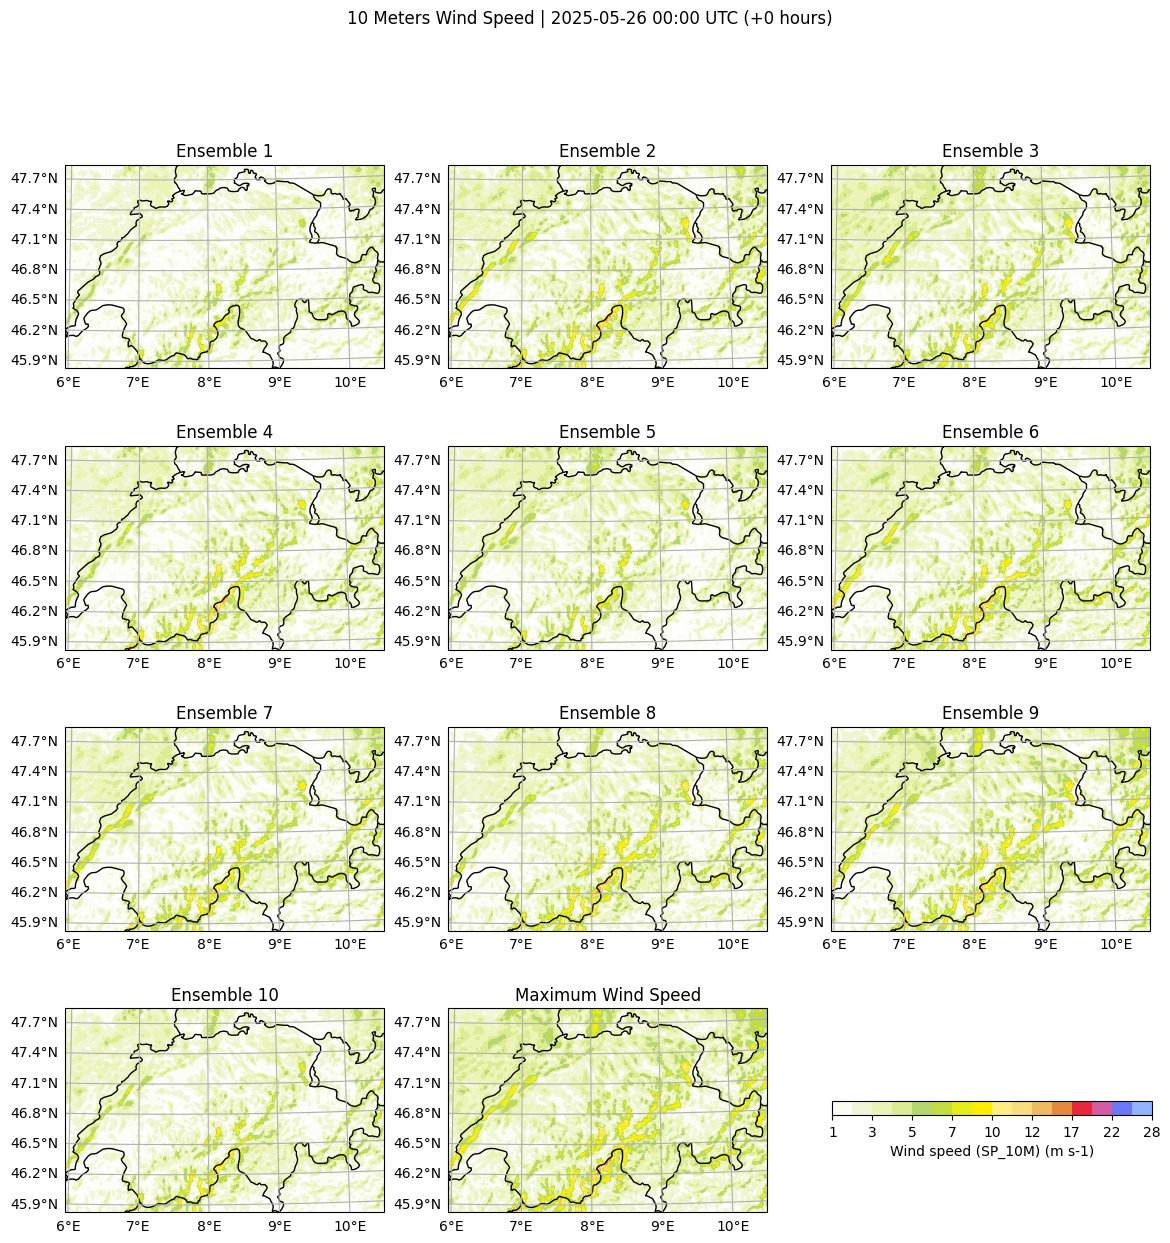

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy import crs as ccrs, feature as cfeature

from plot_utils.load_colormaps import load_ncl_rgb_colors

# === Config ===
crs_epsg2056 = ccrs.epsg(2056)
nrows, ncols = 4, 3
figsize = (14, 14)


# === Load Custom Colormap ===
def get_custom_cmap(name="wind_17lev"):
    colors, levels = load_ncl_rgb_colors(name)
    cmap = LinearSegmentedColormap.from_list(name, colors)
    return cmap, levels

cmap, cmap_levels = get_custom_cmap()

# === Create Figure ===
fig = plt.figure(figsize=figsize)
last_index = len(wind_swiss_list) - 1

# === Plot Each Wind Field ===
for idx, wind_swiss in enumerate(wind_swiss_list):
    ax = fig.add_subplot(nrows, ncols, idx + 1, projection=crs_epsg2056)
    f = wind_swiss.squeeze()

    c = ax.contourf(destination.x, destination.y, f.values, levels=cmap_levels, cmap=cmap, transform=crs_epsg2056)

    title = "Maximum Wind Speed" if idx == last_index else f"Ensemble {wind_swiss.coords['eps'].values}"
    ax.set_title(title)

    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

# === Colorbar & Annotations ===
wind_param = wind_swiss_list[0].attrs["parameter"]
legend_label = f"{wind_param['name']} ({wind_param['units']})"

# === Set colorbar axis ===
cax = plt.axes((0.673, 0.19, ax.get_position().width, 0.01))
fig.colorbar(c, cax=cax, orientation='horizontal', label=legend_label)

# === Figure Title ===
ref_time = pd.to_datetime(wind_swiss_list[0].coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
lead_time = wind_swiss_list[0].coords["lead_time"].values[0].astype('timedelta64[h]')
title = f"10 Meters Wind Speed | {ref_time} (+{lead_time})"
fig.suptitle(title)

plt.show()